In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'
path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.csv'
path_to_csv_ozgun_target = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.xlsx'

In [3]:
data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)
data_eval = dt.fread(path_to_csv_ozgun).to_pandas()
target_eval = pd.read_excel(path_to_csv_ozgun_target, sheet_name='Sheet2')

In [4]:
data_train.shape

(136, 4076)

In [5]:
original_radiomic_train_data = data_train.filter(regex='original')
original_radiomic_eval_data = data_eval.filter(regex='original')

In [6]:
originalT1_40_train_data = original_radiomic_train_data.filter(regex='40')
originalT1_train_data = original_radiomic_train_data[original_radiomic_train_data.columns.drop(list(original_radiomic_train_data.filter(regex='40|T2')))]

In [7]:
originalT1_40_eval_data = original_radiomic_eval_data.filter(regex='40')
originalT1_eval_data = original_radiomic_eval_data[original_radiomic_eval_data.columns.drop(list(original_radiomic_eval_data.filter(regex='40|T2')))]

In [8]:
original_shape_features_train_data_T1 = originalT1_train_data.filter(regex='shape')
original_shape_features_train_data_T1_40 = originalT1_40_train_data.filter(regex='shape')
print(str(original_radiomic_train_data.shape))
print(str(originalT1_40_train_data.shape))
print(str(original_shape_features_train_data_T1_40.shape))

original_shape_features_eval_data_T1 = originalT1_eval_data.filter(regex='shape')
original_shape_features_eval_data_T1_40 = originalT1_40_eval_data.filter(regex='shape')
print(str(original_radiomic_eval_data.shape))
print(str(originalT1_40_eval_data.shape))
print(str(original_shape_features_eval_data_T1_40.shape))

(136, 321)
(136, 107)
(136, 14)
(50, 214)
(50, 107)
(50, 14)


In [9]:
smallest_nb_of_features_T1_40 = original_shape_features_train_data_T1_40[['original_shape_Elongation_40.0', 'original_shape_Sphericity_40.0', 'original_shape_SurfaceVolumeRatio_40.0',  'original_shape_Flatness_40.0']]
smallest_nb_of_features_T1 = original_shape_features_train_data_T1[['original_shape_Elongation', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 'original_shape_Flatness']]

smallest_nb_of_features_eval_T1_40 = original_shape_features_eval_data_T1_40[['original_shape_Elongation_40.0', 'original_shape_Sphericity_40.0', 'original_shape_SurfaceVolumeRatio_40.0', 'original_shape_Flatness_40.0']]

In [10]:
shape_target_train = data_train[['Shape.1']]
margins_target_train = data_train[['Margins (MR)']]
shape_target_eval = target_eval[['mr_mass_shp.factor']]
margins_target_eval = target_eval[['mr_mass_mrg.factor']]

In [11]:
margins_target_train.loc[margins_target_train['Margins (MR)']== 'Circunscribed'] = 'Circumscribed'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
margins_target_train.value_counts()

Margins (MR) 
Irregular        74
Spiculated       59
Circumscribed     3
Name: count, dtype: int64

In [13]:
margins_target_eval.value_counts()

mr_mass_mrg.factor
Irregular             28
Spiculated            19
Circumscribed          3
Name: count, dtype: int64

In [14]:
label_encoder = LabelEncoder()
margins_target_train['Margins (MR)']= label_encoder.fit_transform(margins_target_train['Margins (MR)']) 
margins_target_eval['mr_mass_mrg.factor']= label_encoder.transform(margins_target_eval['mr_mass_mrg.factor'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
margins_target_train.value_counts()

Margins (MR)
1               74
2               59
0                3
Name: count, dtype: int64

In [16]:
margins_target_eval.value_counts()

mr_mass_mrg.factor
1                     28
2                     19
0                      3
Name: count, dtype: int64

In [17]:
margins_target_train.loc[margins_target_train['Margins (MR)']==1, 'Margins (MR)'] = 0
margins_target_train.loc[margins_target_train['Margins (MR)']==2, 'Margins (MR)'] = 1
margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==1, 'mr_mass_mrg.factor'] = 0
margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==2, 'mr_mass_mrg.factor'] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: xlabel='Margins (MR)'>

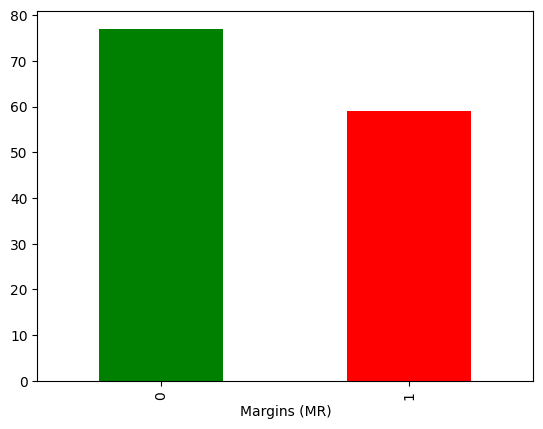

In [18]:
margins_target_train['Margins (MR)'].value_counts().plot.bar(color=['green', 'red'])

<Axes: xlabel='mr_mass_mrg.factor'>

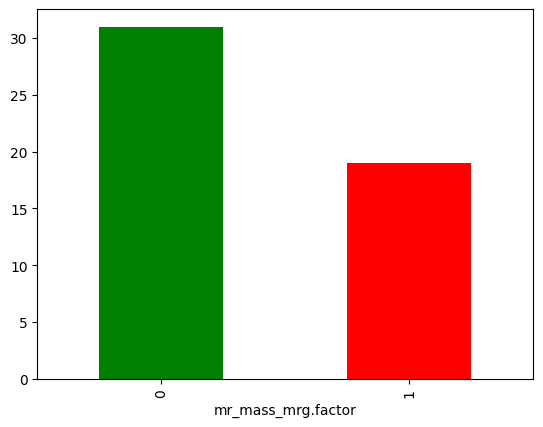

In [19]:
margins_target_eval['mr_mass_mrg.factor'].value_counts().plot.bar(color=['green', 'red'])

In [20]:
scaler_T1_40 = StandardScaler()
scaled_original_radiomic_train_data_T1_40 = pd.DataFrame(scaler_T1_40.fit_transform(original_shape_features_train_data_T1_40), columns=original_shape_features_train_data_T1_40.columns)

scaler_T1 = StandardScaler()
scaled_original_radiomic_train_data_T1 = pd.DataFrame(scaler_T1.fit_transform(original_shape_features_train_data_T1), columns=original_shape_features_train_data_T1.columns)

In [21]:
smallest_nb_of_features_scaler_T1_40 = StandardScaler()
scaled_smallest_nb_of_features_T1_40 = pd.DataFrame(smallest_nb_of_features_scaler_T1_40.fit_transform(smallest_nb_of_features_T1_40), columns=smallest_nb_of_features_T1_40.columns)

smallest_nb_of_features_scaler_T1 = StandardScaler()
scaled_smallest_nb_of_features_T1 = pd.DataFrame(smallest_nb_of_features_scaler_T1.fit_transform(smallest_nb_of_features_T1), columns=smallest_nb_of_features_T1.columns)

In [22]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [23]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, X):

    coef_dict = {}

    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef

    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [24]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):

    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')

    return color_vals

 
# Visualize coefficients
def visualize_coefs(coef_dict):

    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)

    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')

    plt.show()

In [44]:
rs = 123

# Grid search hyperparameters for a logistic regression model

def grid_search_lr(X_train, y_train, kfolds):
    params_grid = {
            'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'penalty': ["l1", "l2"],
            
            'C': np.arange(0.1, 3, 0.1)
                    }

    lr_model = LogisticRegression(random_state=rs, max_iter=1000, solver="liblinear")
    grid_search = GridSearchCV(estimator = lr_model,
                               param_grid = params_grid,
                               scoring='f1',
                               
                               cv = kfolds.split(X_train, y_train), 
                               verbose = 1)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

 

# Grid search hyperparameters for a random forest model

def grid_search_rf(X_train, y_train, kfolds):

    params_grid = {
            'max_depth': [2, 5, 10, 15, 20],
            'n_estimators': [5, 50, 100, 150, 200],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features' : ['sqrt', 'log2', None]#,
            #'class_weight': [None, {0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]

    }

    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring='f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

def grid_search_xgb(X_train, y_train, kfolds, sample_weight):

    params_grid = {
        'max_depth': range (2, 10, 1),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }

    boost_model = XGBClassifier(objective= 'binary:logistic',
                                nthread=4, 
                                scale_pos_weight = sample_weight,
                                random_state=rs)
    grid_search = GridSearchCV(estimator=boost_model,
                               param_grid=params_grid,
                               scoring = 'f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search


    
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    score = cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).mean()
    if name is None:
        print(metric + ' ' + str(score))
    else:
        print(name + ' ' + str(score))
    return score

In [26]:
best_params_logreg_T1_40, grid_search_logreg_T1_40 = grid_search_lr(scaled_original_radiomic_train_data_T1_40, margins_target_train.values.ravel(), skf)
best_params_logreg_T1, grid_search_logreg_T1 = grid_search_lr(scaled_original_radiomic_train_data_T1, margins_target_train.values.ravel(), skf)

best_params_logreg_smallest_nb_of_features_T1_40, grid_search_logreg_smallest_nb_of_features_T1_40 = grid_search_lr(scaled_smallest_nb_of_features_T1_40, margins_target_train.values.ravel(), skf)
best_params_logreg_smallest_nb_of_features_T1, grid_search_logreg_smallest_nb_of_features_T1 = grid_search_lr(scaled_smallest_nb_of_features_T1, margins_target_train.values.ravel(), skf)


Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits


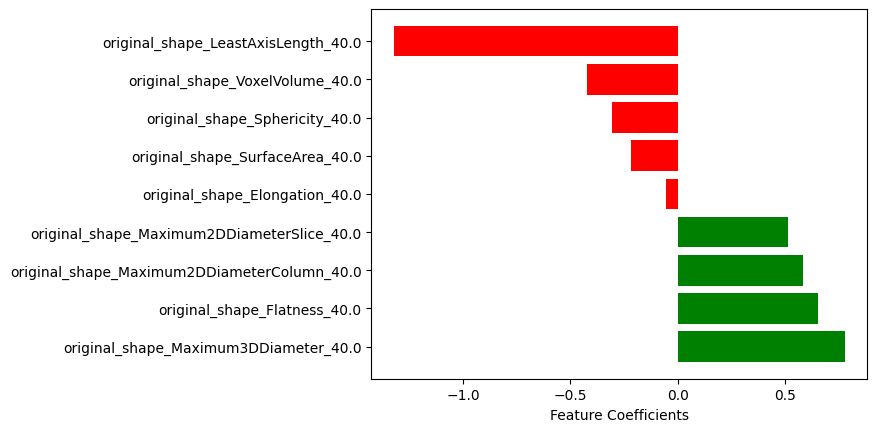

In [27]:
coef_dict = get_feature_coefs(grid_search_logreg_T1_40.best_estimator_, scaled_original_radiomic_train_data_T1_40)
visualize_coefs(coef_dict)

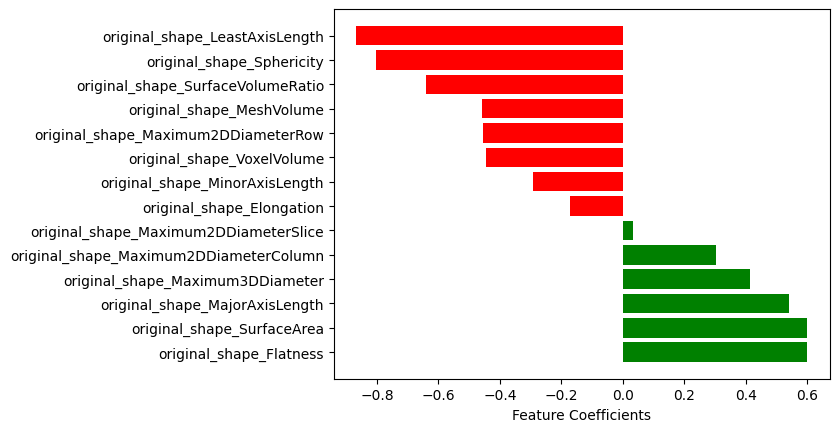

In [28]:
coef_dict = get_feature_coefs(grid_search_logreg_T1.best_estimator_, scaled_original_radiomic_train_data_T1)
visualize_coefs(coef_dict)

In [29]:
background_values_T1_40 = shap.maskers.Independent(scaled_original_radiomic_train_data_T1_40, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_logreg_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(scaled_original_radiomic_train_data_T1_40)

In [30]:
background_values_T1 = shap.maskers.Independent(scaled_original_radiomic_train_data_T1, max_samples=100)
# compute SHAP values
explainer_T1 = shap.Explainer(grid_search_logreg_T1.predict, background_values_T1)
shap_values_T1 = explainer_T1(scaled_original_radiomic_train_data_T1)

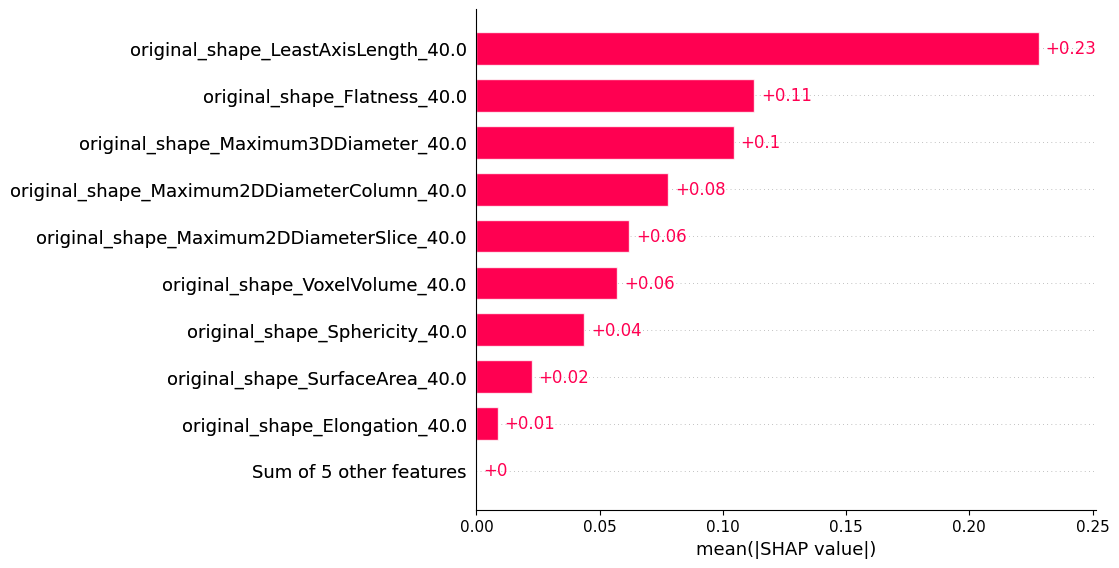

In [31]:
shap.plots.bar(shap_values_T1_40)

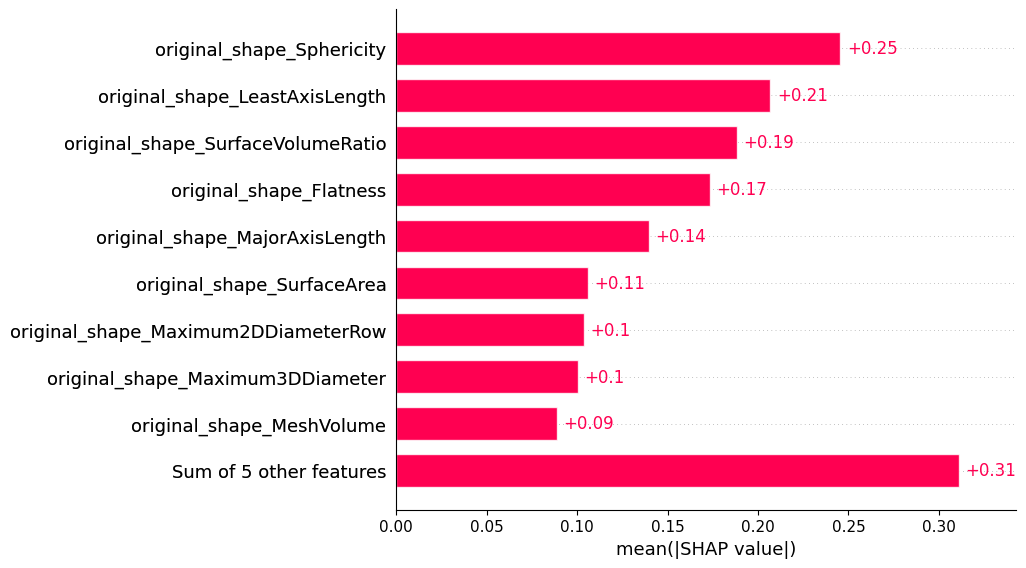

In [32]:
shap.plots.bar(shap_values_T1)

In [45]:
best_params_rf_T1_40, grid_search_randomforest_T1_40 = grid_search_rf(original_shape_features_train_data_T1_40, margins_target_train.values.ravel(), skf)
best_params_rf_T1, grid_search_randomforest_T1 = grid_search_rf(original_shape_features_train_data_T1, margins_target_train.values.ravel(), skf)

best_params_rf_smallest_nb_of_features_T1_40, grid_search_randomforest_smallest_nb_of_features_T1_40 = grid_search_rf(smallest_nb_of_features_T1_40, margins_target_train.values.ravel(), skf)
best_params_rf_smallest_nb_of_features_T1, grid_search_randomforest_smallest_nb_of_features_T1 = grid_search_rf(smallest_nb_of_features_T1, margins_target_train.values.ravel(), skf)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
Fitting 5 folds for each of 375 candidates, totalling 1875 fits
Fitting 5 folds for each of 375 candidates, totalling 1875 fits
Fitting 5 folds for each of 375 candidates, totalling 1875 fits


In [34]:
ratio = float(margins_target_train.value_counts()[0]) / margins_target_train.value_counts()[1]

In [35]:
best_params_xgb_T1_40, grid_search_xgboost_T1_40 = grid_search_xgb(original_shape_features_train_data_T1_40, margins_target_train.values.ravel(), skf, ratio)
best_params_xgb_T1, grid_search_xgboost_T1 = grid_search_xgb(original_shape_features_train_data_T1, margins_target_train.values.ravel(), skf, ratio)

best_params_xgb_smallest_nb_of_features_T1_40, grid_search_xgboost_smallest_nb_of_features_T1_40 = grid_search_xgb(smallest_nb_of_features_T1_40, margins_target_train.values.ravel(), skf, ratio)
best_params_xgb_smallest_nb_of_features_T1, grid_search_xgboost_smallest_nb_of_features_T1 = grid_search_xgb(smallest_nb_of_features_T1, margins_target_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [36]:
def compile_results(model, X, y, kfolds):
    auc = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    balanced_accuracy = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    precision = return_kfold_score(model, X, y, 'precision', kfolds)
    recall = return_kfold_score(model, X, y, 'recall', kfolds)
    f1 = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    specificity = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    sensitivity = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index = sensitivity + specificity - 1
    print('youden index: ' + str(youden_index))

In [46]:
print('Logistic Regression_T1_40')
compile_results(grid_search_logreg_T1_40.best_estimator_, scaled_original_radiomic_train_data_T1_40, margins_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_40')
compile_results(grid_search_randomforest_T1_40.best_estimator_, original_shape_features_train_data_T1_40, margins_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_40')
compile_results(grid_search_xgboost_T1_40.best_estimator_, original_shape_features_train_data_T1_40, margins_target_train.values.ravel(), skf)

Logistic Regression_T1_40
roc_auc 0.5957512626262627
balanced_accuracy 0.5195833333333333
precision 0.44383394383394387
recall 1.0
f1 0.6146274209432103
specificity 0.03916666666666666
sensitivity 1.0
youden index: 0.03916666666666657

Random Forest_T1_40
roc_auc 0.6405587121212122
balanced_accuracy 0.6141287878787878
precision 0.5676923076923076
recall 0.5924242424242424
f1 0.5727114624505928
specificity 0.6358333333333334
sensitivity 0.5924242424242424
youden index: 0.22825757575757577

XG Boost_T1_40
roc_auc 0.6177840909090909
balanced_accuracy 0.6263636363636363
precision 0.5490569561157795
recall 0.656060606060606
f1 0.5938815207780725
specificity 0.5966666666666667
sensitivity 0.656060606060606
youden index: 0.2527272727272727


In [38]:
print('Logistic Regression_T1_DCE')
compile_results(grid_search_logreg_T1.best_estimator_, scaled_original_radiomic_train_data_T1, margins_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_DCE')
compile_results(grid_search_randomforest_T1.best_estimator_, original_shape_features_train_data_T1, margins_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_DCE')
compile_results(grid_search_xgboost_T1.best_estimator_, original_shape_features_train_data_T1, margins_target_train.values.ravel(), skf)

Logistic Regression_T1_DCE
roc_auc 0.6403914141414141
balanced_accuracy 0.6527272727272727
precision 0.5851248751248752
recall 0.6954545454545454
f1 0.6286304347826086
specificity 0.61
sensitivity 0.6954545454545454
youden index: 0.3054545454545454

Random Forest_T1_DCE
roc_auc 0.6812247474747475
balanced_accuracy 0.6659848484848485
precision 0.5664318034906269
recall 0.8136363636363637
f1 0.6619875124875125
specificity 0.5183333333333333
sensitivity 0.8136363636363637
youden index: 0.331969696969697

XG Boost_T1_DCE
roc_auc 0.6008017676767677
balanced_accuracy 0.6179545454545454
precision 0.575
recall 0.5909090909090909
f1 0.5681203007518797
specificity 0.645
sensitivity 0.5909090909090909
youden index: 0.23590909090909085


In [47]:
print('Logistic Regression_T1_40_small')
compile_results(grid_search_logreg_smallest_nb_of_features_T1_40.best_estimator_, scaled_smallest_nb_of_features_T1_40, margins_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_40_small')
compile_results(grid_search_randomforest_smallest_nb_of_features_T1_40.best_estimator_, scaled_smallest_nb_of_features_T1_40, margins_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_40_small')
compile_results(grid_search_xgboost_smallest_nb_of_features_T1_40.best_estimator_, scaled_smallest_nb_of_features_T1_40, margins_target_train.values.ravel(), skf)

Logistic Regression_T1_40_small
roc_auc 0.574861111111111
balanced_accuracy 0.50625
precision 0.437037037037037
recall 1.0
f1 0.6080971659919028
specificity 0.0125
sensitivity 1.0
youden index: 0.012499999999999956

Random Forest_T1_40_small
roc_auc 0.5297821969696971
balanced_accuracy 0.5649621212121211
precision 0.5104895104895105
recall 0.509090909090909
f1 0.50372444946358
specificity 0.6208333333333333
sensitivity 0.509090909090909
youden index: 0.1299242424242424

XG Boost_T1_40_small
roc_auc 0.6150031565656565
balanced_accuracy 0.6306439393939394
precision 0.5599849170437405
recall 0.6621212121212121
f1 0.6038815207780726
specificity 0.5991666666666666
sensitivity 0.6621212121212121
youden index: 0.26128787878787874


In [40]:
print('Logistic Regression_T1_small')
compile_results(grid_search_logreg_smallest_nb_of_features_T1.best_estimator_, scaled_smallest_nb_of_features_T1, margins_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_small')
compile_results(grid_search_randomforest_smallest_nb_of_features_T1.best_estimator_, scaled_smallest_nb_of_features_T1, margins_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_small')
compile_results(grid_search_xgboost_smallest_nb_of_features_T1.best_estimator_, scaled_smallest_nb_of_features_T1, margins_target_train.values.ravel(), skf)

Logistic Regression_T1_small
roc_auc 0.6174431818181818
balanced_accuracy 0.5383333333333333
precision 0.45525925925925925
recall 1.0
f1 0.6250063829011198
specificity 0.07666666666666666
sensitivity 1.0
youden index: 0.07666666666666666

Random Forest_T1_small
roc_auc 0.672165404040404
balanced_accuracy 0.6247348484848485
precision 0.5241486068111455
recall 0.846969696969697
f1 0.6450574712643679
specificity 0.4025
sensitivity 0.846969696969697
youden index: 0.249469696969697

XG Boost_T1_small
roc_auc 0.6383364898989898
balanced_accuracy 0.6257954545454545
precision 0.5710658622423328
recall 0.5757575757575758
f1 0.5631691297208539
specificity 0.6758333333333333
sensitivity 0.5757575757575758
youden index: 0.251590909090909


In [41]:
def compute_pred(model, X_test):
    return model.predict(X_test)

LogisticRegression(C=2.5000000000000004, class_weight={0: 0.2, 1: 0.8},
                   max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')
sensitivity: 1.0
specificity: 0.0967741935483871
youden_index: 0.09677419354838701
balanced_accuracy: 0.5483870967741935
roc_auc: 0.5483870967741935
precision: 0.40425531914893614
recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        31
           1       0.40      1.00      0.58        19

    accuracy                           0.44        50
   macro avg       0.70      0.55      0.38        50
weighted avg       0.77      0.44      0.33        50

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=5,
                       random_state=123)
sensitivity: 0.5789473684210527
specificity: 0.6774193548387096
youden_index: 0.2563667232597622
balanced_accuracy: 0.6281833616298811
roc_auc: 0.6281833616298812
precision: 0.523809523809

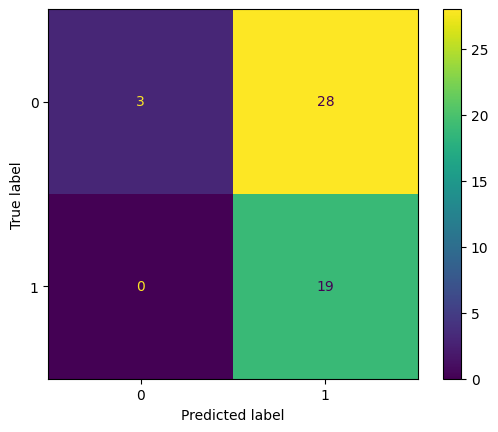

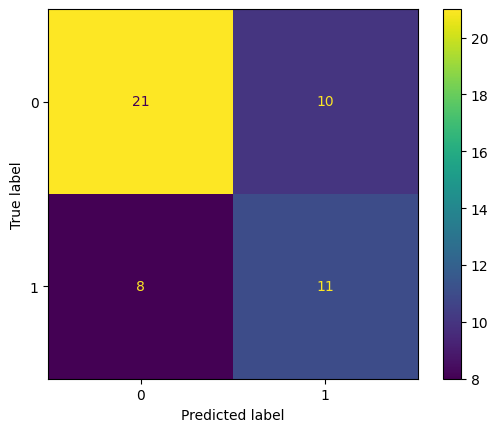

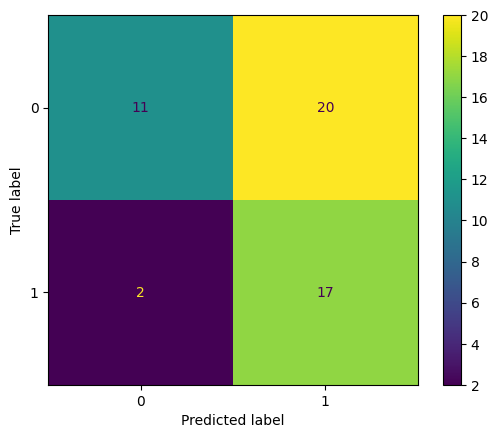

In [49]:
for model in [grid_search_logreg_T1_40.best_estimator_, grid_search_randomforest_T1_40.best_estimator_, grid_search_xgboost_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(scaler_T1_40.transform(original_shape_features_eval_data_T1_40), columns=original_shape_features_eval_data_T1_40.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, margins_target_eval)))
        
    else:
        y_pred = compute_pred(model, original_shape_features_eval_data_T1_40)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, original_shape_features_eval_data_T1_40, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, original_shape_features_eval_data_T1_40, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, original_shape_features_eval_data_T1_40, margins_target_eval)+ scoring['sensitivity'](model, original_shape_features_eval_data_T1_40, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, original_shape_features_eval_data_T1_40, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, original_shape_features_eval_data_T1_40, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, original_shape_features_eval_data_T1_40, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, original_shape_features_eval_data_T1_40, margins_target_eval)))

    print(classification_report(margins_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(margins_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    

LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=1000,
                   random_state=123, solver='liblinear')
sensitivity: 1.0
specificity: 0.0
youden_index: 0.0
balanced_accuracy: 0.5
roc_auc: 0.5
precision: 0.38
recall: 1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.38      1.00      0.55        19

    accuracy                           0.38        50
   macro avg       0.19      0.50      0.28        50
weighted avg       0.14      0.38      0.21        50

RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10,
                       min_samples_split=20, n_estimators=5, random_state=123)
sensitivity: 0.8421052631578947
specificity: 0.16129032258064516
youden_index: 0.00339558573853993
balanced_accuracy: 0.50169779286927
roc_auc: 0.5016977928692699
precision: 0.38095238095238093
recall: 0.8421052631578947
              precision    recall  f1-score   support

     

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


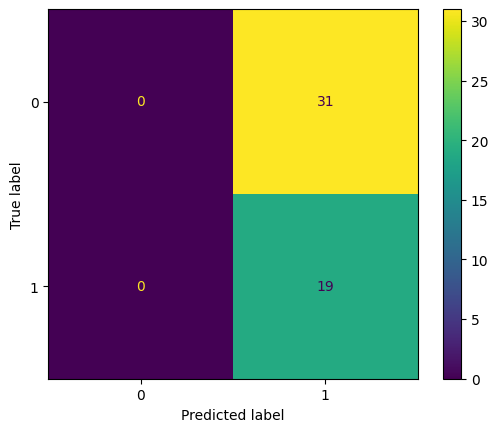

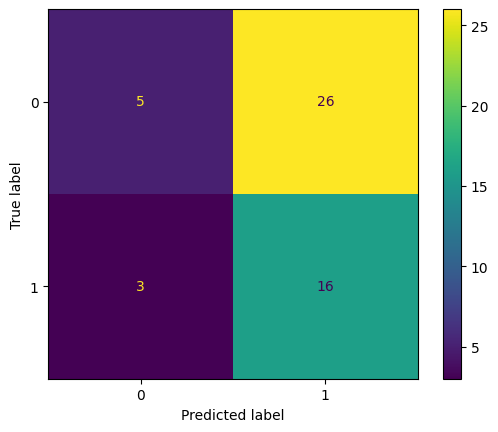

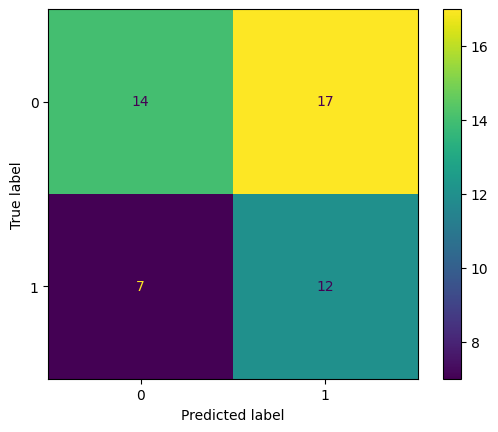

In [43]:
for model in [grid_search_logreg_smallest_nb_of_features_T1_40.best_estimator_, grid_search_randomforest_smallest_nb_of_features_T1_40.best_estimator_, grid_search_xgboost_smallest_nb_of_features_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_smallest_nb_of_features_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(smallest_nb_of_features_scaler_T1_40.transform(smallest_nb_of_features_eval_T1_40), columns=smallest_nb_of_features_eval_T1_40.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, margins_target_eval)))
        
    else:
        y_pred = compute_pred(model, smallest_nb_of_features_eval_T1_40)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval)+ scoring['sensitivity'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, smallest_nb_of_features_eval_T1_40, margins_target_eval)))

    print(classification_report(margins_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(margins_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()